# Project 1 Revisited - Part 2 Global Explanations

In [1]:
#fullname: Hannah Ploutz

## Imports

In [36]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn.inspection import permutation_importance
from lime.lime_tabular import LimeTabularExplainer


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

## Functions

In [3]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

## Loading Objects from a Joblib

In [4]:
## Load the joblib file stored in the models folder
fname = "best-models.joblib"

loaded = joblib.load(fname)
# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'RandomForestRegressor', 'LinearRegression'])

In [5]:
## Saving the loaded objects as separate varaibles

## Saving the loaded objects as separate varaibles

X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg_final = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

X_train.head()

pipeline-1__Item_Weight  pipeline-1__Item_Visibility  \
7394                   10.195                     0.000000   
2736                    7.435                     0.084452   
475                    14.300                     0.127542   
7357                   20.500                     0.112585   
4532                   15.850                     0.007145   

      pipeline-1__Item_MRP  pipeline-1__Outlet_Establishment_Year  \
7394              139.5838                                 2009.0   
2736              165.2158                                 1997.0   
475                84.9224                                 1997.0   
7357              192.0478                                 1999.0   
4532               41.0480                                 2004.0   

      pipeline-2__Item_Fat_Content_Low Fat  \
7394                                   0.0   
2736                                   1.0   
475                                    1.0   
7357                                   0.0   
4532                                   0.0   

      pipeline-2__Item_Fat_Content_Regular  \
7394                                   1.0   
2736                                   0.0   
475                                    0.0   
7357                                   1.0   
4532                                   1.0   

      pipeline-2__Item_Type_Baking Goods  pipeline-2__Item_Type_Breads  \
7394                                 0.0                           0.0   
2736                                 0.0                           0.0   
475                                  0.0                           0.0   
7357                                 0.0                           0.0   
4532                                 0.0                           0.0   

      pipeline-2__Item_Type_Breakfast  pipeline-2__Item_Type_Canned  \
7394                              0.0                           0.0   
2736                              0.0                           0.0   
475                               0.0                           0.0   
7357                              0.0                           0.0   
4532                              0.0                           0.0   

      pipeline-2__Item_Type_Dairy  pipeline-2__Item_Type_Frozen Foods  \
7394                          0.0                                 1.0   
2736                          0.0                                 0.0   
475                           0.0                                 1.0   
7357                          0.0                                 0.0   
4532                          0.0                                 0.0   

      pipeline-2__Item_Type_Fruits and Vegetables  \
7394                                          0.0   
2736                                          0.0   
475                                           0.0   
7357                                          1.0   
4532                                          0.0   

      pipeline-2__Item_Type_Hard Drinks  \
7394                                0.0   
2736                                0.0   
475                                 0.0   
7357                                0.0   
4532                                0.0   

      pipeline-2__Item_Type_Health and Hygiene  \
7394                                       0.0   
2736                                       0.0   
475                                        0.0   
7357                                       0.0   
4532                                       0.0   

      pipeline-2__Item_Type_Household  pipeline-2__Item_Type_Meat  \
7394                              0.0                         0.0   
2736                              0.0                         0.0   
475                               0.0                         0.0   
7357                              0.0                         0.0   
4532                              0.0                         0.0   

      pipeline-2__Item_Type_Others  pipeline-2__Item_Type_S

In [6]:
evaluate_regression(lin_reg_final,X_train,y_train, X_test, y_test)

In [7]:
evaluate_regression(rf_reg,X_train,y_train, X_test, y_test)

## Permutation Importance

In [8]:
## run performatation_importance on the rf  using the test data and random_state=SEED
rf_results = permutation_importance(rf_reg, X_test, y_test,scoring='r2',
                                random_state=SEED)
rf_results.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [9]:
## save the average importances as a Series
rf_perm_importances = pd.Series(rf_results['importances_mean'], index=rf_reg.feature_names_in_)
rf_perm_importances

pipeline-1__Item_Weight                       -0.007742
pipeline-1__Item_Visibility                   -0.001873
pipeline-1__Item_MRP                           0.718047
pipeline-1__Outlet_Establishment_Year          0.011727
pipeline-2__Item_Fat_Content_Low Fat          -0.001759
pipeline-2__Item_Fat_Content_Regular          -0.002126
pipeline-2__Item_Type_Baking Goods            -0.000796
pipeline-2__Item_Type_Breads                  -0.000100
pipeline-2__Item_Type_Breakfast                0.000154
pipeline-2__Item_Type_Canned                  -0.000648
pipeline-2__Item_Type_Dairy                   -0.002707
pipeline-2__Item_Type_Frozen Foods            -0.001457
pipeline-2__Item_Type_Fruits and Vegetables   -0.000001
pipeline-2__Item_Type_Hard Drinks             -0.000801
pipeline-2__Item_Type_Health and Hygiene      -0.001219
pipeline-2__Item_Type_Household               -0.002291
pipeline-2__Item_Type_Meat                     0.000164
pipeline-2__Item_Type_Others                  -0

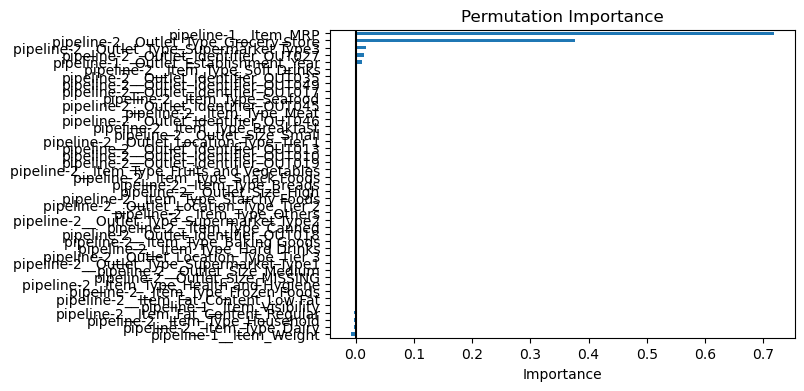

<AxesSubplot: title={'center': 'Permutation Importance'}, xlabel='Importance'>

In [10]:
# Use our plot_importances function, but change title to "Permutation Importance"
plot_importances(rf_perm_importances, title='Permutation Importance')

### LinearRegression Permutation Importance

In [11]:
## run performatation_importance on the lin_reg  using the test data and random_state=SEED
results_linreg = permutation_importance(lin_reg_final, X_test, y_test, scoring='r2', random_state=SEED)
results_linreg.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

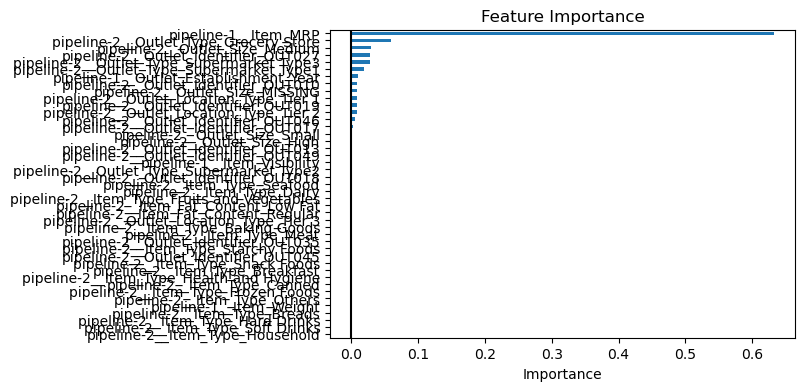

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [12]:
## Make into a series called perm_importances_linreg
linreg_perm_importances = pd.Series(results_linreg['importances_mean'], 
                                    index=lin_reg_final.feature_names_in_)

plot_importances(linreg_perm_importances)

## Applying Shap

In [13]:
# Import and init shap
import shap
shap.initjs()

In [14]:
# Take a sample of the training data (nsampel=500, use random_state=SEED)
X_shap = shap.sample(X_train, nsamples = 500, random_state=SEED)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

pipeline-1__Item_Weight  pipeline-1__Item_Visibility  \
8312                    16.10                     0.034300   
5169                     9.60                     0.014210   
5250                    20.60                     0.030505   
5911                    20.35                     0.054277   
5737                     6.30                     0.127647   

      pipeline-1__Item_MRP  pipeline-1__Outlet_Establishment_Year  \
8312              253.2356                                 2004.0   
5169              188.1872                                 2004.0   
5250              212.6244                                 2004.0   
5911              117.3466                                 2009.0   
5737              207.9270                                 1999.0   

      pipeline-2__Item_Fat_Content_Low Fat  \
8312                                   1.0   
5169                                   0.0   
5250                                   0.0   
5911                                   1.0   
5737                                   1.0   

      pipeline-2__Item_Fat_Content_Regular  \
8312                                   0.0   
5169                                   1.0   
5250                                   1.0   
5911                                   0.0   
5737                                   0.0   

      pipeline-2__Item_Type_Baking Goods  pipeline-2__Item_Type_Breads  \
8312                                 0.0                           0.0   
5169                                 0.0                           0.0   
5250                                 0.0                           0.0   
5911                                 0.0                           0.0   
5737                                 0.0                           0.0   

      pipeline-2__Item_Type_Breakfast  pipeline-2__Item_Type_Canned  \
8312                              0.0                           0.0   
5169                              0.0                           0.0   
5250                              0.0                           0.0   
5911                              0.0                           0.0   
5737                              0.0                           1.0   

      pipeline-2__Item_Type_Dairy  pipeline-2__Item_Type_Frozen Foods  \
8312                          0.0                                 0.0   
5169                          0.0                                 0.0   
5250                          1.0                                 0.0   
5911                          0.0                                 0.0   
5737                          0.0                                 0.0   

      pipeline-2__Item_Type_Fruits and Vegetables  \
8312                                          1.0   
5169                                          0.0   
5250                                          0.0   
5911                                          0.0   
5737                                          0.0   

      pipeline-2__Item_Type_Hard Drinks  \
8312                                0.0   
5169                                0.0   
5250                                0.0   
5911                                0.0   
5737                                0.0   

      pipeline-2__Item_Type_Health and Hygiene  \
8312                                       0.0   
5169                                       0.0   
5250                                       0.0   
5911                                       0.0   
5737                                       0.0   

      pipeline-2__Item_Type_Household  pipeline-2__Item_Type_Meat  \
8312                              0.0                         0.0   
5169                              0.0                         0.0   
5250                              0.0                         0.0   
5911                              0.0                         0.0   
5737                              0.0                         0.0   

      pipeline-2__Item_Type_Others  pipeline-2__Item_Type_S

### Create SHAP explainers for RandomForestRegressor

In [15]:
# Instantiate a Model Explainer with the model
rf_explainer = shap.Explainer(rf_reg)

## Get shap values from the explainer
rf_shap_values = rf_explainer(X_shap) 

In [16]:
rf_shap_values.shape

(500, 43)

### Summary Bar Plots

Text(0.5, 1.0, 'Random Forest SHAP Summary')

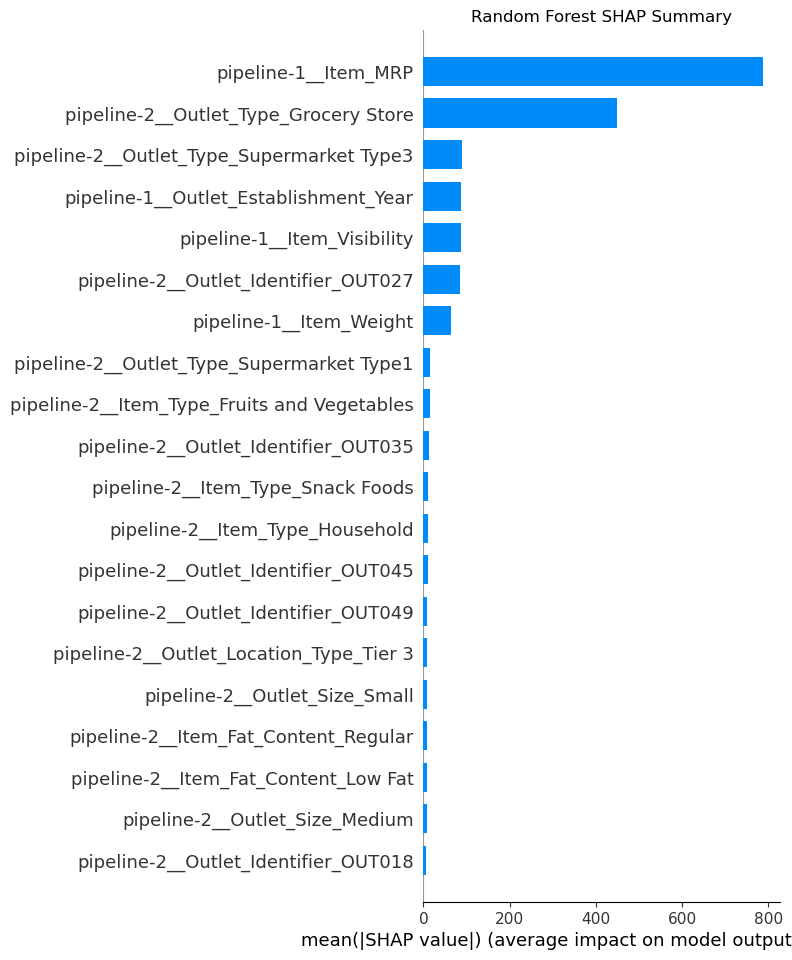

In [17]:
## create a summary plot (bar version)
fig, ax = plt.subplots()
shap.summary_plot(rf_shap_values, features = X_shap, plot_type='bar',
                 show=False)

plt.title('Random Forest SHAP Summary')

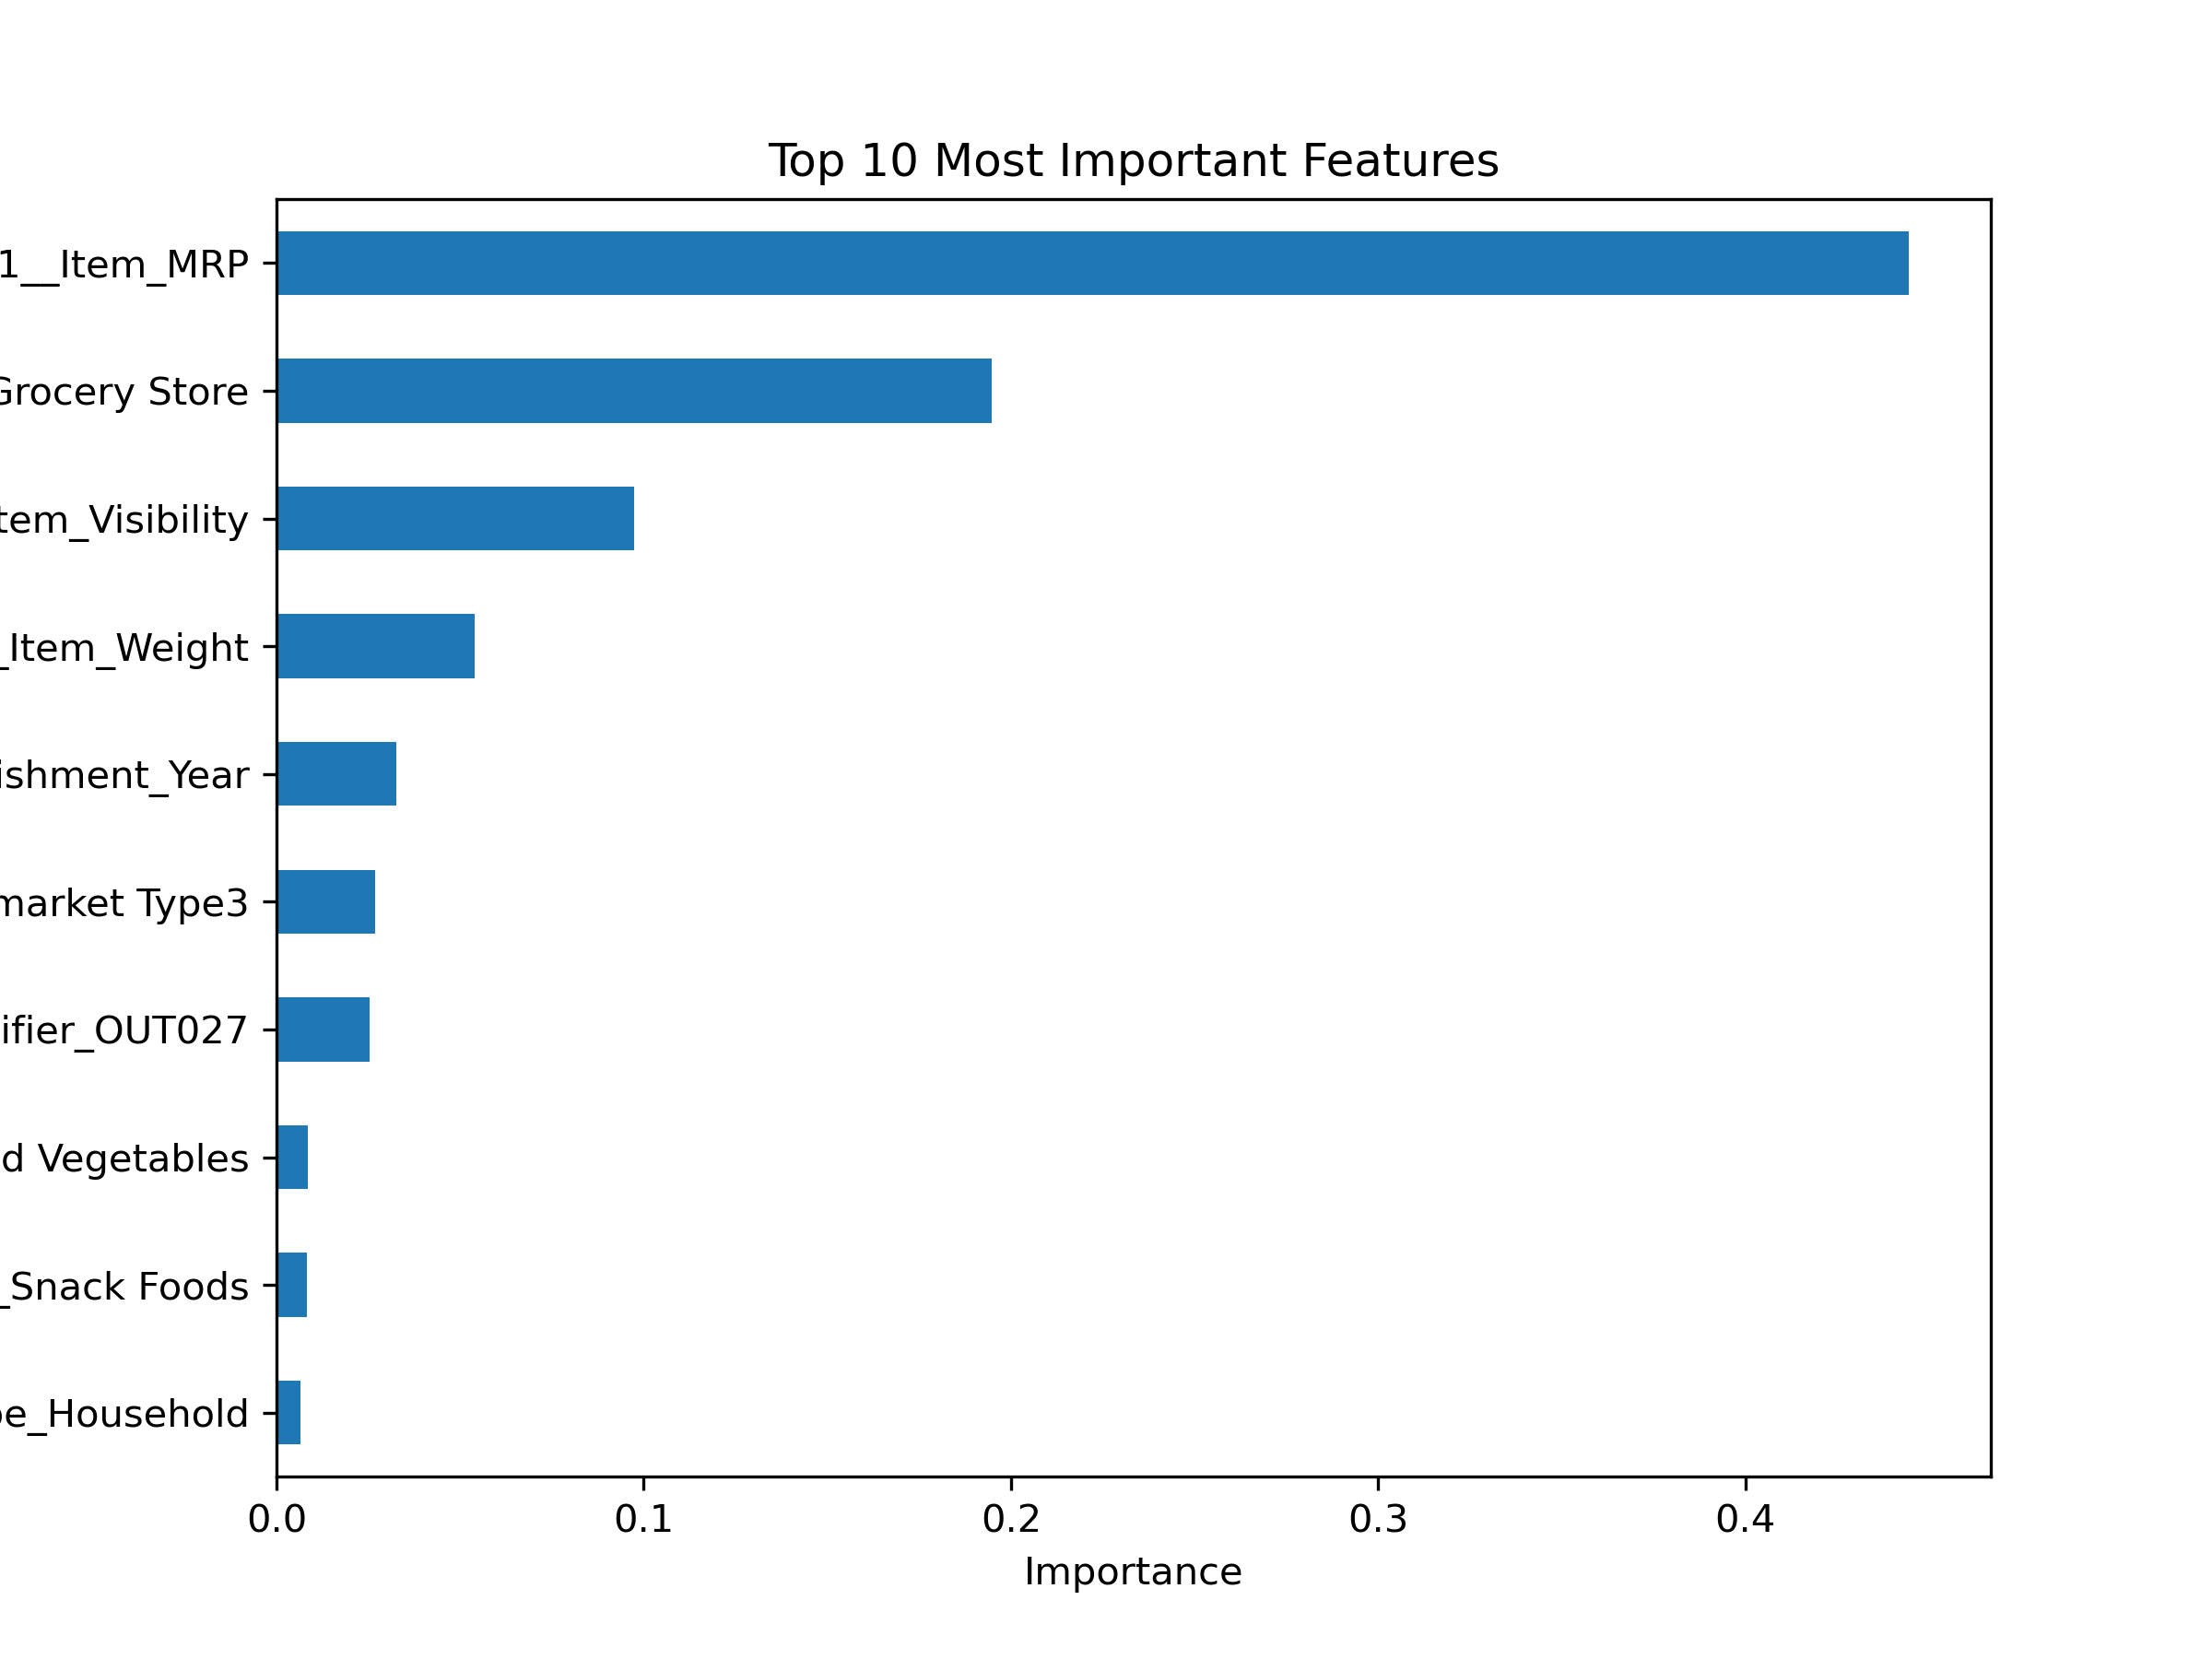

In [18]:
from IPython.display import Image
Image("RandomForestFeatureAnalysis.png")


- Both SHAP and the Feature Importance visualizations display MRP as the most important feature
- They both also share the similarity for the Grocery Store, and start to differ right after that
- Shap shows the third most important being Supermarket Type 3 while the feature importance shows Item Visbility

In [19]:
fig.savefig('ShapImageBar.png',dpi=300);

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


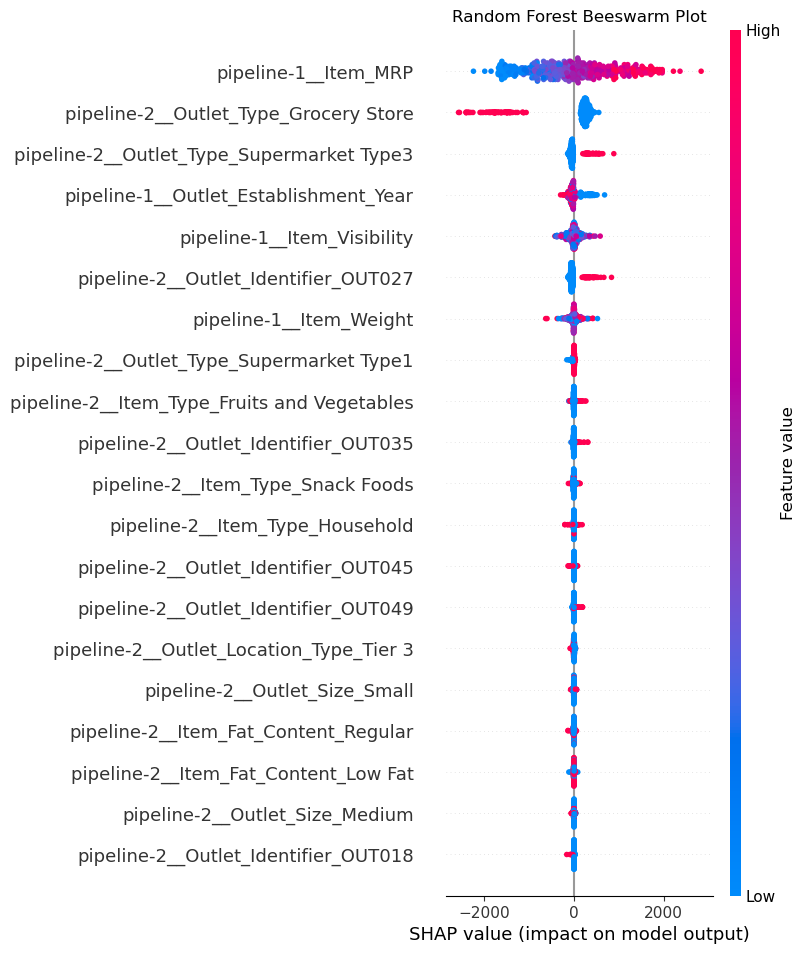

In [20]:
## create a summary plot for Random Forest (dot/default version)
fig, ax = plt.subplots()
shap.summary_plot(rf_shap_values, features=X_shap, show=False)

plt.title('Random Forest Beeswarm Plot')
plt.show()

- The most important feature with this Shap dot chart is definitely Item_MRP
- The Higher the value of the Item_MRP the higher in importance it is
- The Grocery store type coming in second, with the lower value of the the Outlet Type being more impactful
- The third most impactful feature would be Supermarket Type 3, where the higher values had a higher impact

In [21]:
fig.savefig('ShapImageDot.png',dpi=300);

## Local Explanations

In [22]:
print(X_shap.index[:5])

Int64Index([8312, 5169, 5250, 5911, 5737], dtype='int64')


In [23]:
## Making a vers of shap vars with 0-based integer index 
# so what it matches the index for the shap_vallues
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

pipeline-1__Item_Weight  pipeline-1__Item_Visibility  pipeline-1__Item_MRP  \
0                    16.10                     0.034300              253.2356   
1                     9.60                     0.014210              188.1872   
2                    20.60                     0.030505              212.6244   
3                    20.35                     0.054277              117.3466   
4                     6.30                     0.127647              207.9270   

   pipeline-1__Outlet_Establishment_Year  \
0                                 2004.0   
1                                 2004.0   
2                                 2004.0   
3                                 2009.0   
4                                 1999.0   

   pipeline-2__Item_Fat_Content_Low Fat  pipeline-2__Item_Fat_Content_Regular  \
0                                   1.0                                   0.0   
1                                   0.0                                   1.0   
2                                   0.0                                   1.0   
3                                   1.0                                   0.0   
4                                   1.0                                   0.0   

   pipeline-2__Item_Type_Baking Goods  pipeline-2__Item_Type_Breads  \
0                                 0.0                           0.0   
1                                 0.0                           0.0   
2                                 0.0                           0.0   
3                                 0.0                           0.0   
4                                 0.0                           0.0   

   pipeline-2__Item_Type_Breakfast  pipeline-2__Item_Type_Canned  \
0                              0.0                           0.0   
1                              0.0                           0.0   
2                              0.0                           0.0   
3                              0.0                           0.0   
4                              0.0                           1.0   

   pipeline-2__Item_Type_Dairy  pipeline-2__Item_Type_Frozen Foods  \
0                          0.0                                 0.0   
1                          0.0                                 0.0   
2                          1.0                                 0.0   
3                          0.0                                 0.0   
4                          0.0                                 0.0   

   pipeline-2__Item_Type_Fruits and Vegetables  \
0                                          1.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   

   pipeline-2__Item_Type_Hard Drinks  \
0                                0.0   
1                                0.0   
2                                0.0   
3                                0.0   
4                                0.0   

   pipeline-2__Item_Type_Health and Hygiene  pipeline-2__Item_Type_Household  \
0                                       0.0                              0.0   
1                                       0.0                              0.0   
2                                       0.0                              0.0   
3                                       0.0                              0.0   
4                                       0.0                              0.0   

   pipeline-2__Item_Type_Meat  pipeline-2__Item_Type_Others  \
0                         0.0                           0.0   
1                         0.0                           0.0   
2                         0.0                           0.0   
3                         0.0                           0.0   
4                         0.0                           0.0   

   pipeline-2__Item_Type_Seafood  pipeline-2__Item_Type_Snack Foods  \
0                            0.0  

### High MRP

In [25]:
# what is the max/range of Item_MRP
X_shap_local['pipeline-1__Item_MRP'].describe()

count    500.000000
mean     138.157716
std       60.897346
min       32.655800
25%       93.172500
50%      141.265400
75%      181.390350
max      266.188400
Name: pipeline-1__Item_MRP, dtype: float64

In [26]:
## saving the index of the most MRP
idx_high_mrp = X_shap_local['pipeline-1__Item_MRP'].idxmax()
idx_high_mrp

231

In [27]:
# checking the feature values for selected example
X_shap_local.iloc[idx_high_mrp]

pipeline-1__Item_Weight                          19.850000
pipeline-1__Item_Visibility                       0.005243
pipeline-1__Item_MRP                            266.188400
pipeline-1__Outlet_Establishment_Year          1999.000000
pipeline-2__Item_Fat_Content_Low Fat              1.000000
pipeline-2__Item_Fat_Content_Regular              0.000000
pipeline-2__Item_Type_Baking Goods                0.000000
pipeline-2__Item_Type_Breads                      0.000000
pipeline-2__Item_Type_Breakfast                   0.000000
pipeline-2__Item_Type_Canned                      0.000000
pipeline-2__Item_Type_Dairy                       1.000000
pipeline-2__Item_Type_Frozen Foods                0.000000
pipeline-2__Item_Type_Fruits and Vegetables       0.000000
pipeline-2__Item_Type_Hard Drinks                 0.000000
pipeline-2__Item_Type_Health and Hygiene          0.000000
pipeline-2__Item_Type_Household                   0.000000
pipeline-2__Item_Type_Meat                        0.0000

In [28]:
## what was the actual MRP?
y_shap_local.iloc[idx_high_mrp]

3179.8608

#### Shap Force Plot

In [34]:
## plotting example force plot for highest MRP (from rf)
shap.force_plot(rf_explainer.expected_value,
               shap_values=rf_shap_values[idx_high_mrp].values,
               features = X_shap_local.iloc[idx_high_mrp])

- The base value is 2,145
- The SHAP value is 3,424.20
- The features that are pushing the greatest and winning the prediction are:
> - Outlet Type 0 and Item MRP = 266.2
- The features that lost in making the prediction are:
> - Item visibility of 0.005 and Outlet establishment year 

#### LIME

In [37]:
## Create a lime explainer with X_shap_local with regression as the mode
## Don't need to show it the model yet.
lime_explainer = LimeTabularExplainer(training_data=X_shap_local.values,
                                      feature_names = X_shap_local.columns,
                                      mode='regression')

lime_explainer

In [39]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_high_mrp],
                                      rf_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


- The predicted value was closer to the min of 58.46
- The most impactful features was Outlet Type Grocery Store and Item MRP

### High Visibility

In [30]:
# what is the max/range of Visibility
X_shap_local['pipeline-1__Item_Visibility'].describe()

count    500.000000
mean       0.069633
std        0.050303
min        0.000000
25%        0.030553
50%        0.060461
75%        0.096495
max        0.306543
Name: pipeline-1__Item_Visibility, dtype: float64

In [31]:
## saving the index of the most Visibility
idx_high_vis = X_shap_local['pipeline-1__Item_Visibility'].idxmax()
idx_high_vis

331

In [32]:
# checking the feature values for selected example
X_shap_local.iloc[idx_high_vis]

pipeline-1__Item_Weight                          12.852984
pipeline-1__Item_Visibility                       0.306543
pipeline-1__Item_MRP                            147.310200
pipeline-1__Outlet_Establishment_Year          1985.000000
pipeline-2__Item_Fat_Content_Low Fat              1.000000
pipeline-2__Item_Fat_Content_Regular              0.000000
pipeline-2__Item_Type_Baking Goods                0.000000
pipeline-2__Item_Type_Breads                      0.000000
pipeline-2__Item_Type_Breakfast                   0.000000
pipeline-2__Item_Type_Canned                      0.000000
pipeline-2__Item_Type_Dairy                       0.000000
pipeline-2__Item_Type_Frozen Foods                0.000000
pipeline-2__Item_Type_Fruits and Vegetables       0.000000
pipeline-2__Item_Type_Hard Drinks                 0.000000
pipeline-2__Item_Type_Health and Hygiene          0.000000
pipeline-2__Item_Type_Household                   0.000000
pipeline-2__Item_Type_Meat                        0.0000

In [33]:
## what was the actual visibility of the item?
y_shap_local.iloc[idx_high_vis]

291.6204

#### Shap Force Plot

In [35]:
## plotting example force plot for highest MRP (from rf)
shap.force_plot(rf_explainer.expected_value,
               shap_values=rf_shap_values[idx_high_vis].values,
               features = X_shap_local.iloc[idx_high_vis])

- The base value is 2,145
- The SHAP value is 361.28
- The features that are pushing the greatest and winning the prediction are:
> - Outlet Type Grocery Store 1
- The features that lost in making the prediction are:
> - Outlet Establishment Year 1985

#### LIME

In [40]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_high_vis],
                                      rf_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


- The predicted value was closer to the min of 48.25
- The most impactful features to the positive raiting was:
> - Item MRP, Year of 1985, Item Type Others and Hard Drinks